In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.stattools import coint, adfuller # adfuller 추가

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False
print("✅ 라이브러리 준비 완료")

# 딥러닝 클러스터링 결과 (이전 분석 결과)
clusters_dict = {
    0: ['AAPL', 'GOOGL', 'GOOG', 'TSLA', 'AMD', 'AZN', 'SHOP', 'PDD', 'AMGN', 'SNY', 'SNPS', 'IBKR', 'CDNS', 'CSX', 'WDAY', 'ALNY', 'FAST', 'PCAR', 'IDXX', 'EXC', 'EBAY', 'BKR', 'EA', 'KDP', 'MPWR'],
    1: ['COST', 'PLTR', 'LIN', 'ISRG', 'APP', 'GILD', 'ADP', 'ROP', 'CME', 'CTAS', 'EQIX', 'MNST', 'PAYX', 'TRIP'],
    2: ['NVDA', 'MSFT', 'AMZN', 'META', 'AVGO', 'NFLX', 'ASML', 'CSCO', 'TXN', 'INTU', 'BKNG', 'ARM', 'MU', 'AMAT', 'LRCX', 'ADI', 'MELI', 'KLAC', 'DASH', 'CRWD', 'CEG', 'HOOD', 'NTES', 'MDLZ', 'COIN', 'MAR', 'ADSK', 'AXON', 'NDAQ', 'DDOG', 'TTWO', 'ZS'],
    3: ['PEP', 'INTC', 'REGN'],
    4: ['QCOM', 'ADBE', 'CMCSA', 'SBUX', 'ABNB', 'PYPL', 'MRVL', 'NXPI', 'JD', 'TEAM', 'FANG'],
    5: ['HON', 'PANW', 'VRTX', 'TRI', 'FTNT'],
    6: ['TMUS', 'ORLY', 'AEP', 'ROST', 'CPRT', 'KMB', 'XEL', 'ARGX']
}

all_tickers_in_clusters = []
for cluster_tickers in clusters_dict.values():
    all_tickers_in_clusters.extend(cluster_tickers)
all_tickers_in_clusters = sorted(list(set(all_tickers_in_clusters)))

start_date = '2022-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
print(f"📈 총 {len(all_tickers_in_clusters)}개 종목의 데이터를 수집합니다...")
all_data_px = {}
for ticker in all_tickers_in_clusters:
    try:
        price_df = fdr.DataReader(ticker, start_date, end_date)
        if not price_df.empty:
            all_data_px[ticker] = price_df[['Close']]
    except Exception as e:
        print(f"  - {ticker} 데이터 수집 실패: {e}")

data = pd.concat(all_data_px, axis=1)
data.columns = data.columns.droplevel(1) 
data = data.dropna() 
print("\n✅ 데이터 수집 및 준비 완료")
print(data.head())

✅ 라이브러리 준비 완료
📈 총 98개 종목의 데이터를 수집합니다...

✅ 데이터 수집 및 준비 완료
                  AAPL        ABNB        ADBE         ADI         ADP  \
2023-09-14  175.740005  144.119995  552.159973  179.669998  248.289993   
2023-09-15  175.009995  142.750000  528.890015  178.139999  245.309998   
2023-09-18  177.970001  142.550003  532.419983  179.720001  247.279999   
2023-09-19  179.070007  141.850006  541.690002  178.750000  245.839996   
2023-09-20  175.490005  138.009995  535.780029  176.080002  243.869995   

                  ADSK        AEP        ALNY        AMAT         AMD  ...  \
2023-09-14  216.669998  80.599998  193.059998  144.570007  106.629997  ...   
2023-09-15  213.350006  80.040001  184.990005  138.250000  101.489998  ...   
2023-09-18  213.520004  80.230003  179.770004  140.270004  102.370003  ...   
2023-09-19  212.059998  80.059998  175.660004  137.710007  101.610001  ...   
2023-09-20  207.729996  80.449997  175.520004  136.970001  100.339996  ...   

                  TMUS      

In [2]:
def find_pairs(data, tickers_list, method='cointegration', threshold=0.01):
    pairs = []
    for i in range(len(tickers_list)):
        for j in range(i + 1, len(tickers_list)):
            S1 = data.get(tickers_list[i])
            S2 = data.get(tickers_list[j])
          
            if S1 is None or S2 is None:
                continue

            if len(S1) < 50: continue

            if method == 'cointegration':
                _, pvalue, _ = coint(S1, S2)
                if pvalue < threshold: 
                    pairs.append((tickers_list[i], tickers_list[j], pvalue))
            
            elif method == 'r_squared':
                model = LinearRegression()
                X_rank = S1.rank(pct=True).values.reshape(--1, 1)
                y_rank = S2.rank(pct=True).values
                model.fit(X_rank, y_rank)
                score = model.score(X_rank, y_rank)
                if score > threshold: 
                    pairs.append((tickers_list[i], tickers_list[j], score))

            elif method == 'mutual_info':
                X = S1.values.reshape(--1, 1)
                y = S2.values
                score = mutual_info_regression(X, y)[0]
                if score > threshold: 
                    pairs.append((tickers_list[i], tickers_list[j], score))
                    
    return pairs

print("\n--- 1. 공적분(Cointegration) 기반 페어 탐색 (p-value < 0.01) ---")
all_cointegration_pairs = []
for i, cluster in enumerate(clusters_dict.values()):
    pairs = find_pairs(data, cluster, method='cointegration', threshold=0.01)
    if pairs:
        print(f"  [클러스터 {i}]")
        for p in pairs: print(f"    - {p[0]}-{p[1]}: {p[2]:.4f}")
        all_cointegration_pairs.extend(pairs)

print("\n✅ 페어 탐색 완료!")


--- 1. 공적분(Cointegration) 기반 페어 탐색 (p-value < 0.01) ---
  [클러스터 0]
    - AMD-CSX: 0.0044
    - PDD-AMGN: 0.0074
    - PDD-IBKR: 0.0069
    - PDD-BKR: 0.0039
  [클러스터 2]
    - BKNG-AXON: 0.0008
  [클러스터 5]
    - HON-PANW: 0.0011

✅ 페어 탐색 완료!



✅ 공적분 p-value 기준 상위 5개 페어에 대한 심층 분석을 시작합니다.

[1/5] 페어 분석: BKNG vs AXON
 (전체 기간 공적분 p-value: 0.0008)

--- 초기 60일 스프레드 정상성 검증 (ADF Test) ---
초기 헤지 비율: 0.0314
ADF Test p-value: 0.7395
⚠️ p-value >= 0.05, 스프레드가 정상성을 가지지 않을 수 있습니다.


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_3357/1849108735.py:75: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(buy_signals.index, buy_signals, 'g^', markersize=10, label=f'Buy Spread (Short {pair_to_analyze[0]}, Long {pair_to_analyze[1]})')


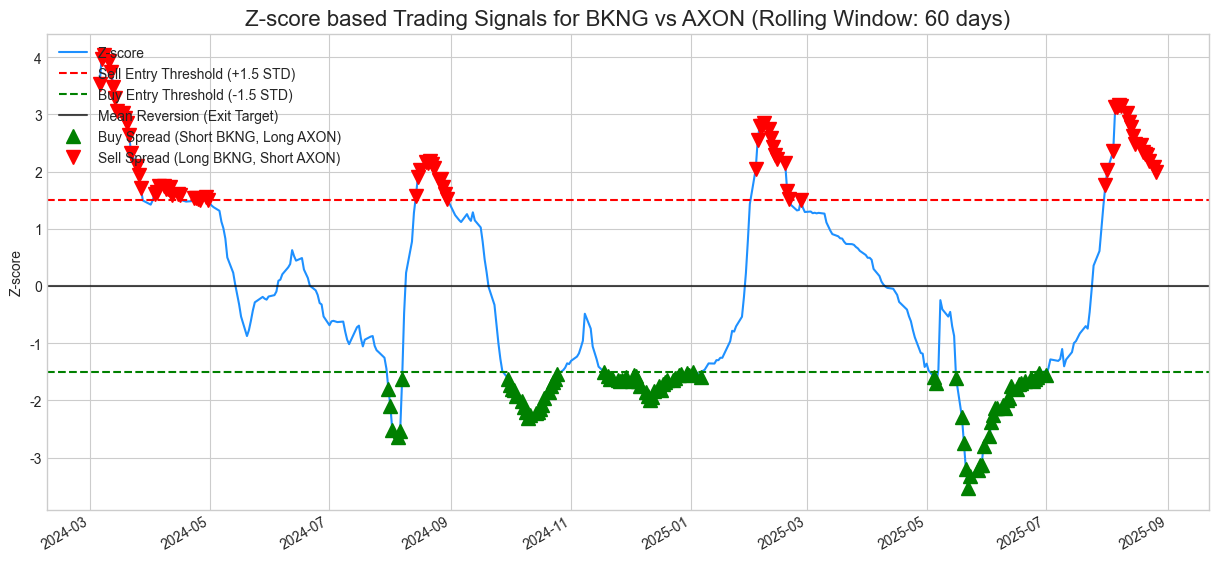


[2/5] 페어 분석: HON vs PANW
 (전체 기간 공적분 p-value: 0.0011)

--- 초기 60일 스프레드 정상성 검증 (ADF Test) ---
초기 헤지 비율: 0.8951
ADF Test p-value: 0.7002
⚠️ p-value >= 0.05, 스프레드가 정상성을 가지지 않을 수 있습니다.


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_3357/1849108735.py:75: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(buy_signals.index, buy_signals, 'g^', markersize=10, label=f'Buy Spread (Short {pair_to_analyze[0]}, Long {pair_to_analyze[1]})')


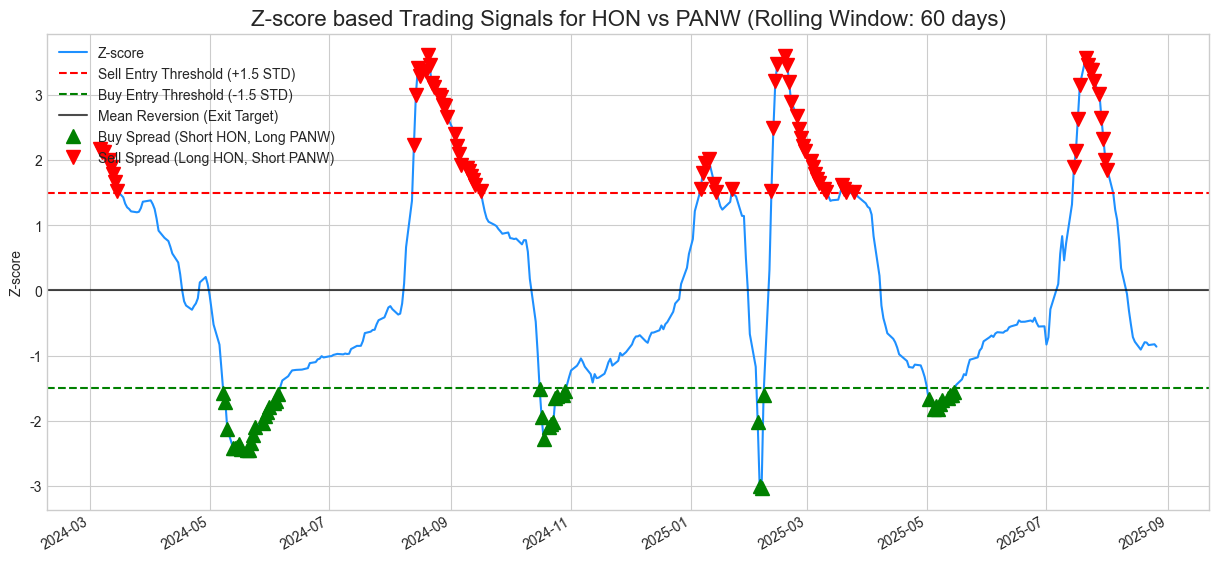


[3/5] 페어 분석: PDD vs BKR
 (전체 기간 공적분 p-value: 0.0039)

--- 초기 60일 스프레드 정상성 검증 (ADF Test) ---
초기 헤지 비율: -0.0515
ADF Test p-value: 0.0004
💡 p-value < 0.05, 스프레드는 정상성을 가질 가능성이 높습니다. (전략의 전제 충족)


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_3357/1849108735.py:75: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(buy_signals.index, buy_signals, 'g^', markersize=10, label=f'Buy Spread (Short {pair_to_analyze[0]}, Long {pair_to_analyze[1]})')


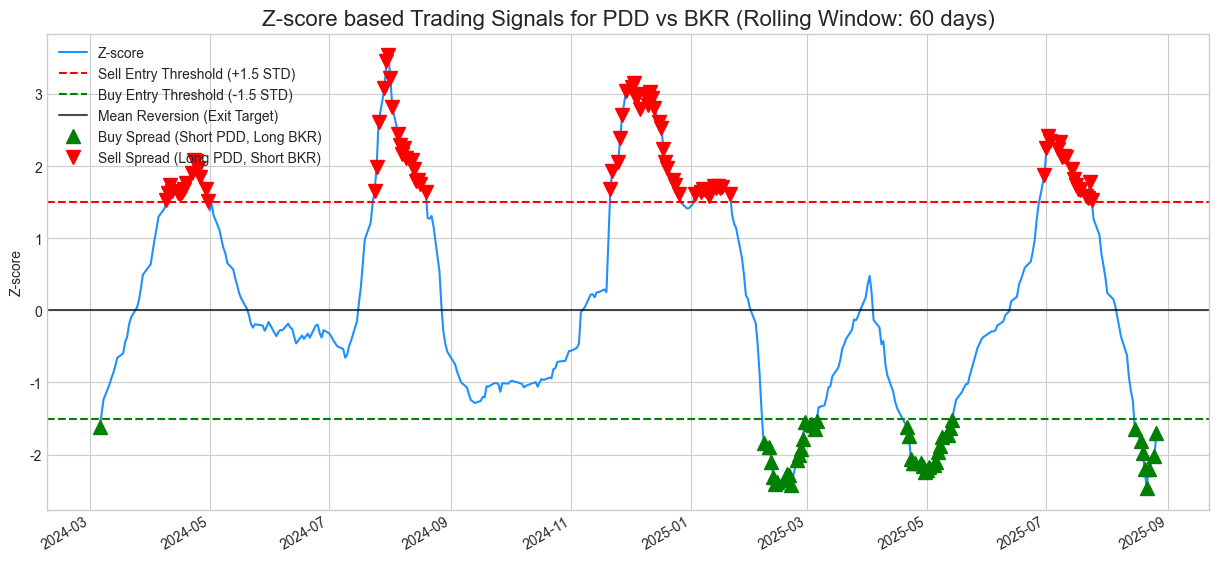


[4/5] 페어 분석: AMD vs CSX
 (전체 기간 공적분 p-value: 0.0044)

--- 초기 60일 스프레드 정상성 검증 (ADF Test) ---
초기 헤지 비율: 0.0763
ADF Test p-value: 0.3266
⚠️ p-value >= 0.05, 스프레드가 정상성을 가지지 않을 수 있습니다.


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_3357/1849108735.py:75: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(buy_signals.index, buy_signals, 'g^', markersize=10, label=f'Buy Spread (Short {pair_to_analyze[0]}, Long {pair_to_analyze[1]})')


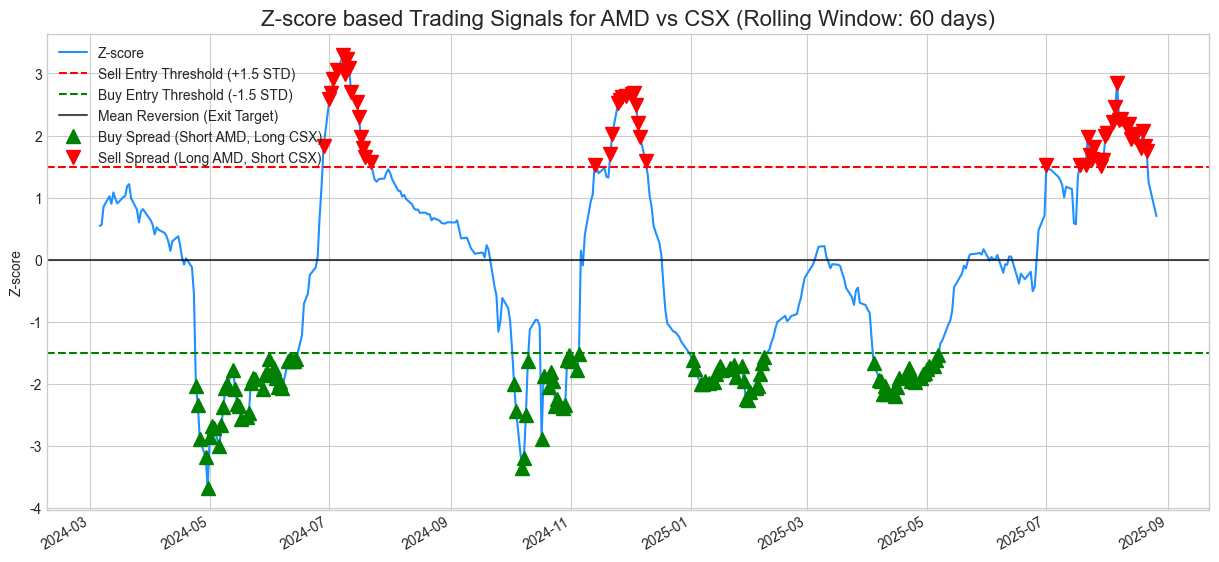


[5/5] 페어 분석: PDD vs IBKR
 (전체 기간 공적분 p-value: 0.0069)

--- 초기 60일 스프레드 정상성 검증 (ADF Test) ---
초기 헤지 비율: -0.0479
ADF Test p-value: 0.1967
⚠️ p-value >= 0.05, 스프레드가 정상성을 가지지 않을 수 있습니다.


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_3357/1849108735.py:75: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot(buy_signals.index, buy_signals, 'g^', markersize=10, label=f'Buy Spread (Short {pair_to_analyze[0]}, Long {pair_to_analyze[1]})')


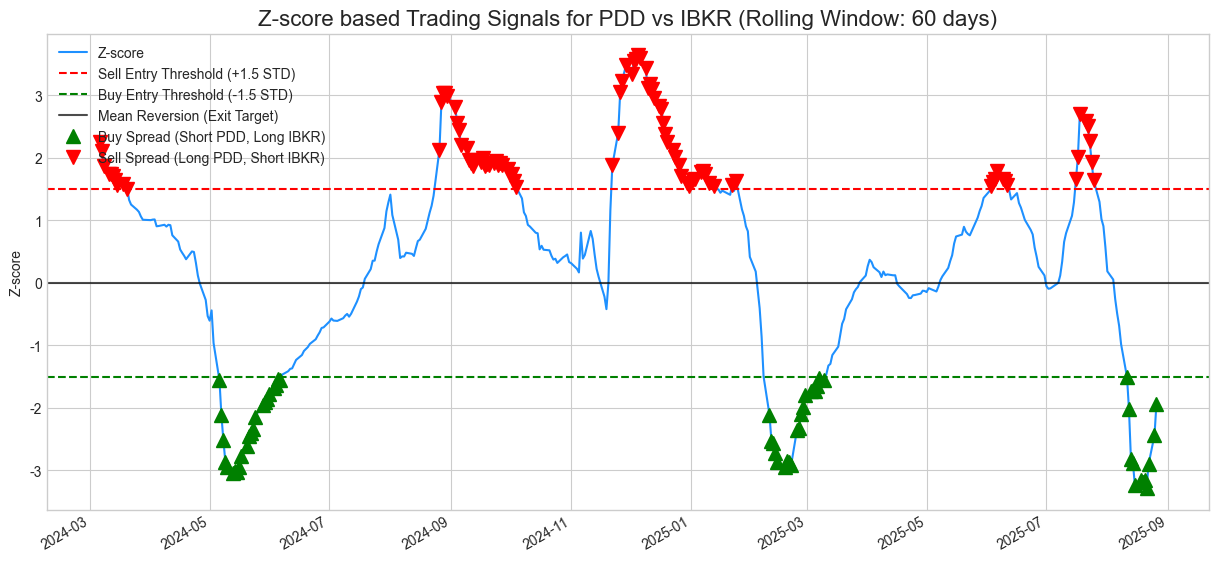

In [4]:
top_n_to_analyze = 5

if all_cointegration_pairs:
    all_cointegration_pairs.sort(key=lambda x: x[2])
    
    print(f"\n✅ 공적분 p-value 기준 상위 {top_n_to_analyze}개 페어에 대한 심층 분석을 시작합니다.")
    
    for i, pair_info in enumerate(all_cointegration_pairs[:top_n_to_analyze]):
        
        pair_to_analyze = (pair_info[0], pair_info[1])
        coint_p_value = pair_info[2]
        
        print("\n" + "="*80)
        print(f"[{i+1}/{top_n_to_analyze}] 페어 분석: {pair_to_analyze[0]} vs {pair_to_analyze[1]}")
        print(f" (전체 기간 공적분 p-value: {coint_p_value:.4f})")
        print("="*80)

        try:
            S1 = data[pair_to_analyze[0]]
            S2 = data[pair_to_analyze[1]]

            window = 60 

            if len(S1) < window or len(S2) < window:
                print("⚠️ 데이터 기간이 window보다 짧아 분석을 건너뜁니다.")
                continue

            initial_S1 = S1.iloc[:window]
            initial_S2 = S2.iloc[:window]
            initial_S1_const = sm.add_constant(initial_S1)
            results = sm.OLS(initial_S2, initial_S1_const).fit()
            initial_hedge_ratio = results.params.iloc[1]
            initial_spread = initial_S2 - initial_hedge_ratio * initial_S1

            adf_result = adfuller(initial_spread)
            adf_p_value = adf_result[1]

            print(f"\n--- 초기 {window}일 스프레드 정상성 검증 (ADF Test) ---")
            print(f"초기 헤지 비율: {initial_hedge_ratio:.4f}")
            print(f"ADF Test p-value: {adf_p_value:.4f}")
            if adf_p_value < 0.05:
                print("💡 p-value < 0.05, 스프레드는 정상성을 가질 가능성이 높습니다. (전략의 전제 충족)")
            else:
                print("⚠️ p-value >= 0.05, 스프레드가 정상성을 가지지 않을 수 있습니다.")

            # 2. 롤링 헤지 비율 및 Z-스코어 계산
            rolling_hedge_ratios = pd.Series(index=S1.index[window:])
            for t in range(window, len(S1)):
                S1_window = S1.iloc[t-window:t]
                S2_window = S2.iloc[t-window:t]
                S1_const_window = sm.add_constant(S1_window)
                model = sm.OLS(S2_window, S1_const_window).fit()
                rolling_hedge_ratios.iloc[t-window] = model.params.iloc[1]

            spread = (S2 - rolling_hedge_ratios * S1).dropna()
            spread_mean = spread.rolling(window=window).mean()
            spread_std = spread.rolling(window=window).std()
            z_score = (spread - spread_mean) / spread_std

            # 3. Z-스코어 시각화 및 시그널 생성
            plt.figure(figsize=(15, 7))
            z_score.plot(label='Z-score', color='dodgerblue')
            plt.axhline(1.5, color='red', linestyle='--', label='Sell Entry Threshold (+1.5 STD)')
            plt.axhline(-1.5, color='green', linestyle='--', label='Buy Entry Threshold (-1.5 STD)')
            plt.axhline(0, color='black', linestyle='-', alpha=0.7, label='Mean Reversion (Exit Target)')

            buy_signals = z_score[z_score < -1.5]
            sell_signals = z_score[z_score > 1.5]
            plt.plot(buy_signals.index, buy_signals, 'g^', markersize=10, label=f'Buy Spread (Short {pair_to_analyze[0]}, Long {pair_to_analyze[1]})')
            plt.plot(sell_signals.index, sell_signals, 'rv', markersize=10, label=f'Sell Spread (Long {pair_to_analyze[0]}, Short {pair_to_analyze[1]})')

            plt.title(f'Z-score based Trading Signals for {pair_to_analyze[0]} vs {pair_to_analyze[1]} (Rolling Window: {window} days)', fontsize=16)
            plt.ylabel('Z-score')
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"❌ 페어 {pair_to_analyze} 분석 중 오류 발생: {e}")

else:
    print("\n⚠️ 분석할 공적분 페어를 찾지 못했습니다.")